**Example use of Schnetpack for atomic forces**

Taken from: https://schnetpack.readthedocs.io/en/stable/tutorials/tutorial_03_force_models.html

First step: import relevant packages and create a working directory:

In [1]:
import schnetpack as spk
import os

forcetut = './forcetut'
if not os.path.exists(forcetut):
    os.makedirs(forcetut)


Now we have a directory called `forcetut`, we will download the internal `MD17` database from `SchNetPack`, which contains energy and forces for small molecules. 

Here we obtain information for ethanol:

In [2]:
from schnetpack.datasets import MD17

ethanol_data = MD17(os.path.join(forcetut,'ethanol.db'), molecule='ethanol')

(For custom data, one needs to use the `AtomsData` class, ensuring that the properties names such as energy, force, etc. are consistent with SchNetPack's internal naming)

Let's check what properties are in our database, by sampling the first `atoms` object (commensurate with an ASE `atoms` object):

In [3]:
atoms, properties = ethanol_data.get_properties(0)

print('Loaded properties:\n', *['{:s}\n'.format(i) for i in properties.keys()])

Loaded properties:
 energy
 forces
 _atomic_numbers
 _positions
 _cell
 _neighbors
 _cell_offset



/usr/local/lib/python3.8/site-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/Users/andrewlogsdail/Library/Python/3.8/lib/python/site-packages/ase/atoms.py:920: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


We're interested in energy and forces for an atomic FF, and it's good to see they are included. Let's check there contents and shape:

In [4]:
print('Forces:\n', properties[MD17.forces])
print('Shape:\n', properties[MD17.forces].shape)

Forces:
 tensor([[ 1.4517e+00,  6.0192e+00,  5.2068e-07],
        [ 1.7953e+01, -5.1624e+00,  3.4900e-07],
        [-4.0884e+00,  2.2590e+01,  3.3088e-06],
        [-1.1416e+00, -9.7469e+00,  7.6473e+00],
        [-1.1416e+00, -9.7469e+00, -7.6473e+00],
        [-2.4821e+00,  4.9335e+00,  4.3700e+00],
        [-2.4821e+00,  4.9335e+00, -4.3700e+00],
        [-5.5148e+00, -3.0207e+00, -8.9093e-09],
        [-2.4393e+00, -1.0838e+01, -6.0721e-08]])
Shape:
 torch.Size([9, 3])


i.e. there are 9 atoms, as we'd expect for ethanol. Great! (Note here that these are `PyTorch` tensors - effectively identical to `Numpy` arrays except can be transfered to other processing units)

As the atoms object is in ASE form, we can view if we don't believe the molecule is actually ethanol:

In [5]:
from ase.visualize import view
view(atoms, viewer='ngl')

**Preparing data**

Now we have gathered the data, we need to prepare for processing. The first step is splitting the data into groups for training and testing:

In [6]:
train, val, test = spk.train_test_split(
        data=ethanol_data,
        num_train=1000,
        num_val=500,
        split_file=os.path.join(forcetut, "split.npz"),
    )

train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100)

Here we have created a training data set with 1000 entries (`train`), a validation set with 500 entries (`val`), and then all remaining data is used for testing (`test`). The indices of each set are stored in the `split.npz` file.

After splitting, the data is loaded for training and validation. The `AtomsLoader` will take care of loading, shuffling, and batching the data during training and evaluation.

At this point, it is perhaps useful to look of the statistics for e.g. the training set, as we will need to precondition (aka normalise) the data:

In [7]:
means, stddevs = train_loader.get_statistics(
    spk.datasets.MD17.energy, divide_by_atoms=True
)

print('Mean atomization energy / atom:      {:12.4f} [kcal/mol]'.format(means[MD17.energy][0]))
print('Std. dev. atomization energy / atom: {:12.4f} [kcal/mol]'.format(stddevs[MD17.energy][0]))

/Users/andrewlogsdail/Library/Python/3.8/lib/python/site-packages/ase/atoms.py:920: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


Mean atomization energy / atom:       -10799.5449 [kcal/mol]
Std. dev. atomization energy / atom:       0.4767 [kcal/mol]


Note that we _only_ need to precondition with respect to energies, as the forces are derivatives of the energy and automatically capture scale. If configurations with differing atomic quantities or species were to be included in the testset, subtraction of the atomic reference energies would also be necessary (to normalise the data).

**Building the model**

Now we have the data prepared, we can start to make our NN model.

Firstly, we need a representation for the atom-wise features (i.e. inter-connectivity descriptor), which is done with `SchNet`. Here we use 3 interaction layers, a 5 Angstrom cosine cutoff with pariwise distances expanded on 25 Gaussions and 128 atom-wise features and convolution filters. 

(I've no idea what varying these parameters does - someone should check these options, as they are key to accuracy of the NN)

In [8]:
n_features = 128

schnet = spk.representation.SchNet(
    n_atom_basis=n_features,
    n_filters=n_features,
    n_gaussians=25,
    n_interactions=3,
    cutoff=5.,
    cutoff_network=spk.nn.cutoff.CosineCutoff
)

We also need an output module for our observable of interest. This is the `AtomWise` object. We will predict the energy, and so precondition with the mean and standard deviation per atom. We also have the forces, which are the derivatives of the energy, so we can include this in the model. Since the forces are the negative of the gradient, `negative_dr` ensures that the correct relationship of these observables in enforced.

In [9]:
energy_model = spk.atomistic.Atomwise(
    n_in=n_features,
    property=MD17.energy,
    mean=means[MD17.energy],
    stddev=stddevs[MD17.energy],
    derivative=MD17.forces,
    negative_dr=True
)

Both models are then combined to an `AtomisticModel`

In [10]:
model = spk.AtomisticModel(representation=schnet, 
                           output_modules=energy_model)

**Training the model**

When training a model, we need to define a loss function which tells us how good/bad our model is. A simple approach could be e.g. the mean squared error. In the current work, as we are also fitting to forces, we need to define a compound function with a bit more complexity (including a parameter to define the emphasis on energy or forces)

See this page for the full details: https://schnetpack.readthedocs.io/en/stable/tutorials/tutorial_03_force_models.html#Training-the-model

In [11]:
import torch

# tradeoff
rho_tradeoff = 0.1

# loss function
def loss(batch, result):
    # compute the mean squared error on the energies
    diff_energy = batch[MD17.energy]-result[MD17.energy]
    err_sq_energy = torch.mean(diff_energy ** 2)

    # compute the mean squared error on the forces
    diff_forces = batch[MD17.forces]-result[MD17.forces]
    err_sq_forces = torch.mean(diff_forces ** 2)

    # build the combined loss function
    err_sq = rho_tradeoff*err_sq_energy + (1-rho_tradeoff)*err_sq_forces

    return err_sq

We also need a method to optimise the model parameters on-the-fly, which is achieved using functionality from `PyTorch`.

In [12]:
from torch.optim import Adam

# build optimizer
optimizer = Adam(model.parameters(), lr=5e-4)

Finally before training, we can define some `hooks` that are called during the training process. This is the same as an observer, and allows e.g. logging of the data (`CSVHook`), which in this case is MAE of energy and forces, and also enforcing learning rate schedules (`ReduceLROnPlateauHook`). In this example, we reduce the learning rate by 0.8 after 5 epochs (periods of learning) without improvement.

In [13]:
# before setting up the trainer, remove previous training checkpoints and logs
%rm -rf ./forcetut/checkpoints
%rm -rf ./forcetut/log.csv

import schnetpack.train as trn

# set up metrics
metrics = [
    spk.metrics.MeanAbsoluteError(MD17.energy),
    spk.metrics.MeanAbsoluteError(MD17.forces)
]

# construct hooks
hooks = [
    trn.CSVHook(log_path=forcetut, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

Now we have all the aspects we need: a `model`, a `hook`, a loss function, and optimizer, and training and validation data. We can then build the trainer.

In [14]:
trainer = trn.Trainer(
    model_path=forcetut,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

And then perform training, here for 10 steps (because of time and computation limitations) but in reality you'd want to run this until completion i.e. with `n_epochs` undefined.

In [15]:
# check if a GPU is available and use a CPU otherwise
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# determine number of epochs and train
n_epochs = 10
trainer.train(device=device, n_epochs=n_epochs)

Thanks to the logging hook we included, we can review the progress of the training process by loading the CSV file and plotting MAEs. Here we just use `matplotlib` to make some nice graphs of the fitting progress.

Validation MAE:
    energy:      2.089 kcal/mol
    forces:      5.021 kcal/mol/Å


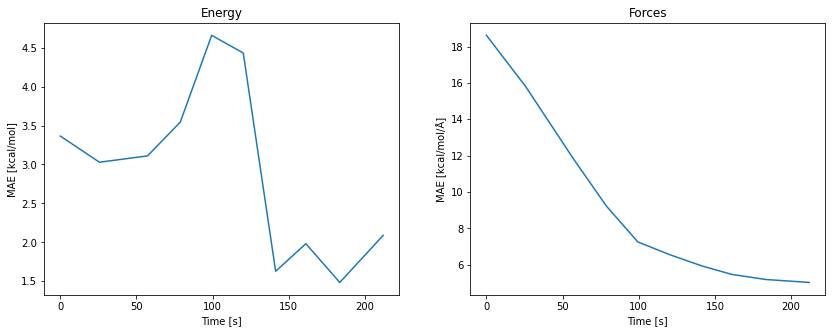

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

# Load logged results
results = np.loadtxt(os.path.join(forcetut, 'log.csv'), skiprows=1, delimiter=',')

# Determine time axis
time = results[:,0]-results[0,0]

# Load the validation MAEs
energy_mae = results[:,4]
forces_mae = results[:,5]

# Get final validation errors
print('Validation MAE:')
print('    energy: {:10.3f} kcal/mol'.format(energy_mae[-1]))
print('    forces: {:10.3f} kcal/mol/\u212B'.format(forces_mae[-1]))

# Construct figure
plt.figure(figsize=(14,5))

# Plot energies
plt.subplot(1,2,1)
plt.plot(time, energy_mae)
plt.title('Energy')
plt.ylabel('MAE [kcal/mol]')
plt.xlabel('Time [s]')

# Plot forces
plt.subplot(1,2,2)
plt.plot(time, forces_mae)
plt.title('Forces')
plt.ylabel('MAE [kcal/mol/\u212B]')
plt.xlabel('Time [s]')

plt.show()

**Using the model**

Once fitted, we want to start using our NN model! The best model is stored within a file called `best_model`, which we can read with the `PyTorch` functionality for loading models.

In [17]:
best_model = torch.load(os.path.join(forcetut, 'best_model'))

Now remember when we split the data into training, validation and testing sets? We want to now use the remaining models for testing.

As for `train` and `val`, firstly we need to create an AtomsLoader to manage the load/manipulation of the testing data. We'll then iteratively load the data, make predictions with the `best_model` and compare those to the _actual_ values, and store the errors for reporting. 

(Be warned MD17 is a big dataset, so this may take some time!)

In [18]:
test_loader = spk.AtomsLoader(test, batch_size=100)

energy_error = 0.0
forces_error = 0.0

for count, batch in enumerate(test_loader):
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)

    # calculate absolute error of energies
    tmp_energy = torch.sum(torch.abs(pred[MD17.energy] - 
                                     batch[MD17.energy]))
    tmp_energy = tmp_energy.detach().cpu().numpy() # detach from graph & convert to numpy
    energy_error += tmp_energy

    # calculate absolute error of forces, where we compute the mean over the n_atoms x 3 dimensions
    tmp_forces = torch.sum(
        torch.mean(torch.abs(pred[MD17.forces] - 
                             batch[MD17.forces]), dim=(1,2))
    )
    tmp_forces = tmp_forces.detach().cpu().numpy() # detach from graph & convert to numpy
    forces_error += tmp_forces

    # log progress
    percent = '{:3.2f}'.format(count/len(test_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")

energy_error /= len(test)
forces_error /= len(test)

print('\nTest MAE:')
print('    energy: {:10.3f} kcal/mol'.format(energy_error))
print('    forces: {:10.3f} kcal/mol/\u212B'.format(forces_error))

/Users/andrewlogsdail/Library/Python/3.8/lib/python/site-packages/ase/atoms.py:920: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


Progress: 99.98%
Test MAE:
    energy:      2.045 kcal/mol
    forces:      5.095 kcal/mol/Å


If the data to feed into the testing is not in SchNetPack form, but alternatively as ASE atoms objects, one can use the `AtomsConverter` object to support translation. 

One can also use the `SpkCalculator` as an interface to ASE:

In [19]:
calculator = spk.interfaces.SpkCalculator(
    model=best_model,
    device=device,
    energy=MD17.energy,
    forces=MD17.forces,
    energy_units='kcal/mol',
    forces_units='kcal/mol/A'
)

atoms.set_calculator(calculator)

print('Prediction:')
print('energy:', atoms.get_total_energy())
print('forces:', atoms.get_forces())

Prediction:
energy: [-4215.2197]
forces: [[-1.08195335e-01  5.57995915e-01 -4.13552328e-07]
 [ 4.52878654e-01 -3.00981879e-01 -2.84317228e-08]
 [ 2.08917528e-01  5.36691725e-01 -1.03388080e-08]
 [-9.04941186e-02 -4.35632199e-01  3.09391230e-01]
 [-9.04941261e-02 -4.35631722e-01 -3.09391409e-01]
 [-1.10555418e-01  1.77823618e-01  1.85089976e-01]
 [-1.10555314e-01  1.77823618e-01 -1.85090140e-01]
 [-3.90917271e-01 -1.09809227e-01  4.65246366e-08]
 [ 2.39415199e-01 -1.68280348e-01  2.26161423e-09]]


It is important to note that the energy units of ASE are eV and eV/Angstrom, so conversion between kcal/mol is necessary in this particular case (There is no reason to be limited to kcal/mol, it is just specific to the MD17 dataset). This change is applied by setting `energy_units` and `forces_units`.

From here, one can do standard calculations of e.g. geometry optimisation, vibrations, stress and molecular dynamics, using ASE functionality.